In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/fruits-360.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

In [6]:
# dimensions of our images.
img_width, img_height = 224, 224 # we set the img_width and img_height according to the pretrained models we are
# going to use. The input size for ResNet-50 is 224 by 224 by 3.

train_data_dir = '/content/fruits-360/Training'
validation_data_dir = '/content/fruits-360/Test'
 
batch_size = 64


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [ ]:
pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=a1d96d301de37a3b34a5894c6d42a1c0c37e093a0080449937ab4afc17cae249
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-resnet


In [8]:
from keras.applications.resnet import ResNet50  
#import inception with pre-trained weights. do not include fully #connected layers
basemodel = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = basemodel.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(131, activation='softmax')(x)
# create the full network so we can train on it
model = Model(inputs=basemodel.input, outputs=predictions)

94781440/94765736 [==============================] - 2s 0us/step


In [11]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=0.00001, momentum=0.9),metrics=['accuracy'])

In [10]:
history_pretrained = model.fit(train_generator,epochs=15, shuffle = True, verbose = 1, validation_data = validation_generator)

Epoch 1/15
1058/1058 [==============================] - 959s 851ms/step - loss: 4.9206 - accuracy: 0.0120 - val_loss: 4.8340 - val_accuracy: 0.0211
Epoch 2/15
1058/1058 [==============================] - 892s 843ms/step - loss: 4.7140 - accuracy: 0.0432 - val_loss: 4.5622 - val_accuracy: 0.0865
Epoch 3/15
1058/1058 [==============================] - 891s 842ms/step - loss: 4.5036 - accuracy: 0.1115 - val_loss: 4.3230 - val_accuracy: 0.1662
Epoch 4/15
1058/1058 [==============================] - 892s 843ms/step - loss: 4.2461 - accuracy: 0.2032 - val_loss: 3.9909 - val_accuracy: 0.2779
Epoch 5/15
1058/1058 [==============================] - 888s 839ms/step - loss: 3.9434 - accuracy: 0.3087 - val_loss: 3.6835 - val_accuracy: 0.3810
Epoch 6/15
1058/1058 [==============================] - 889s 840ms/step - loss: 3.6211 - accuracy: 0.4018 - val_loss: 3.3376 - val_accuracy: 0.4523
Epoch 7/15
1058/1058 [==============================] - 887s 838ms/step - loss: 3.2989 - accuracy: 0.4785 - val_

In [13]:
model.evaluate(validation_generator,verbose=2)

355/355 - 72s - loss: 0.7968 - accuracy: 0.8850


[0.7968447804450989, 0.8850052952766418]

In [14]:
model.save('/content/fruits-360/resnet.h5')



/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
model=tf.keras.models.load_model('/content/fruits-360/resnet.h5')
batch_size = 16
num_of_test_samples=22688
# Y_pred=model.predict(validation_generator)
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = model.predict_generator(validation_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(validation_generator.classes, y_pred)



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


355/355 [==============================] - 71s 198ms/step


In [16]:
print(cm)

[[0 3 2 ... 1 3 3]
 [2 2 1 ... 0 1 0]
 [2 0 2 ... 1 2 3]
 ...
 [0 1 0 ... 0 1 3]
 [1 6 0 ... 3 4 1]
 [1 3 1 ... 1 2 1]]


In [17]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
P=precision_score(validation_generator.classes, y_pred, average="macro")  
print(P*100)
from sklearn.metrics import accuracy_score
A=accuracy_score(validation_generator.classes, y_pred)
print(A*100)
from sklearn.metrics import f1_score
f1=f1_score(validation_generator.classes, y_pred,average='micro')
print(f1*100)

0.79986177891195
0.850669957686883
0.850669957686883


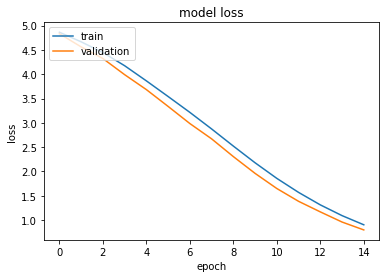

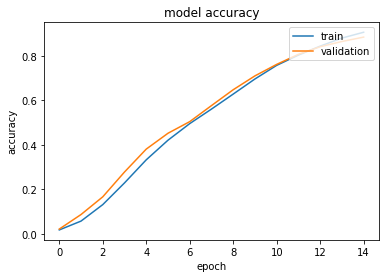

In [18]:
import matplotlib.pyplot as plt
plt.plot(history_pretrained.history['loss'])
plt.plot(history_pretrained.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history_pretrained.history['accuracy'])
plt.plot(history_pretrained.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
 

 

In [19]:
from sklearn.metrics import classification_report
print(classification_report(validation_generator.classes, y_pred))
 

    



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       164
           1       0.01      0.01      0.01       148
           2       0.01      0.01      0.01       160
           3       0.01      0.01      0.01       164
           4       0.00      0.00      0.00       161
           5       0.01      0.01      0.01       164
           6       0.00      0.00      0.00       152
           7       0.01      0.01      0.01       164
           8       0.02      0.03      0.02       164
           9       0.01      0.02      0.01       144
          10       0.01      0.01      0.01       166
          11       0.03      0.01      0.02       164
          12       0.00      0.00      0.00       219
          13       0.01      0.01      0.01       164
          14       0.01      0.01      0.01       143
          15       0.00      0.00      0.00       166
          16       0.01      0.01      0.01       166
          17       0.01    